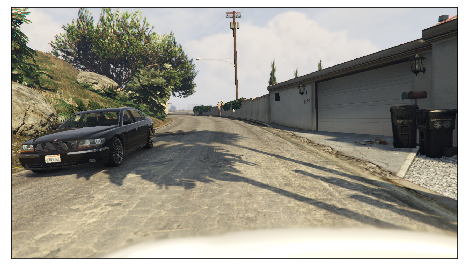

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from tqdm.notebook import tqdm

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2

import numpy as np

import sys
sys.path.append('../')

from depth_Functions import (
    import_raw_colour_image, 
    show_img, 
    show_array_of_images,
    show_function
)
    
from Feature_Extraction import ( 
    create_local_feature_vector
)

from Patches import Patches

bgr = import_raw_colour_image('../GTA_images/Simple/Colour/color_1.raw')
show_img(bgr)

# Theory

In accordance with [3-D Depth Reconstruction from a Single Still Image](https://www.cs.cornell.edu/~asaxena/learningdepth/ijcv_monocular3dreconstruction.pdf) determining the depth of a patch is better defined using information of it's suroundings

## Factors:

### Neighbour comparison

To features of adjacent patches are considered in calcualting the depth of a patch

### Scale:

How the features of a patch changes with scale can indicate it's properties i.e. differentiate grass from sky

### Column comparison

Assuming the image is of the real world, or at least a representation that mimics it, it is possible to use known common characteritics as part of our analysis

In the real world we know that structures do not float and therefore  information can be contained in the vertical column the patch lies in

## Our implementation

To utilise these factors we add multiply our feature vector to contain:
1. The features in the adjacent patches
1. The features of the patch and neighbouring patchs at increased scales
1. The features of the columns

We define:

|||
|-|-|
|Neighbours|Adjacent patches|
|Scales| $1\times1,\ 3\times3,\ 9\times9 $ |
|Columns|4 columns from top to bottom of the image|

In total the global feature vector has a length of $19\times34$: 

$$length =646$$

# Adding global features

patchsize = [6, 8]
nxm = [120, 160]


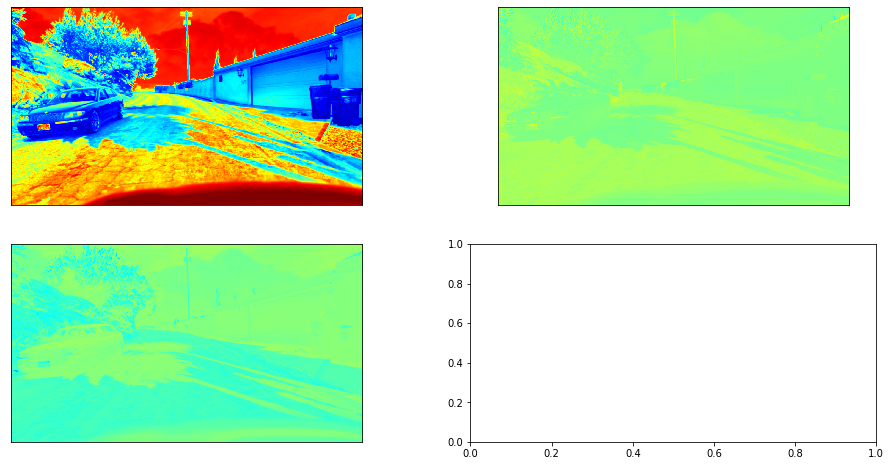

In [11]:
patches = Patches(image=bgr, patchsize=6, convert=cv2.COLOR_BGR2YCrCb, feature_shape=(34,), 
                  neighbour_order=[(0,0),(-1,0),(0,1),(1,0),(0,-1)], scales=[(1,1),(3,3),(9,9)], split_channels=True, heatmap=True)

## Neighbouring patches

We create our patches, the neighbour feature vectors are set to the patches vector

**n.b.** this means edge/corner patches will have their own feature vector recorded as unavailable patches.

e.g. Top left will record left and above neighbour as it's own feature vector

set neighbour vector to (self, above, right, below, left)

**n.b. set_adjacent_features changes the existing array**

In [237]:
show_function(set_adjacent)

def scaled_patch(patch, patchsize, scale, function, sub=False):
    subpatches = []
    centre = (int(scale[0]/2)*patchsize[0], int(scale[1]/2)*patchsize[1])
    order = [(-1,0),(0,1),(1,0),(0,-1)]
    centre_patch = function(patch[centre[0]:centre[0]+patchsize[0], centre[1]:centre[1]+patchsize[1]])
    
    if not sub:
        subpatches[0] = centre_patch

    for (y,x) in order:
        start = (centre[0]+(y*patchsize[0]), centre[1]+(x*patchsize[1]))
        end = (start[0]+patchsize[0], start[1]+patchsize[1])
        if sub:
            subpatches.append(centre_patch - function(patch[start[0]:end[0], start[1]:end[1]]))
        else :
            subpatches.append(function(patch[start[0]:end[0], start[1]:end[1]]))
    return subpatches

In [361]:
patches.patches.shape

(3, 120, 160, 5, 34)

In [362]:
patches.neighbour_order

[(0, 0), (-1, 0), (0, 1), (1, 0), (0, -1)]

In [363]:
patches.process_image(function=create_local_feature_vector)

In [364]:
np.all(patches.patches[0][0][0][0] != patches.patches[0][0][0][2])

True

In [365]:
np.all(patches.patches[0][1][0][1] == patches.patches[0][0][0][0])

True

In [366]:
np.all(patches.patches[0][0][0][2] == patches.patches[0][0][1][0])

True

In [367]:
np.all(patches.patches[0][0][0][3] == patches.patches[0][1][0][0])

True

In [368]:
np.all(patches.patches[0][0][1][4] == patches.patches[0][0][0][0])

True

In [369]:
np.all(patches.patches[1:]==0)

True

In [56]:
visual = Patches(bgr, 60, (1,), scales=[(1,1), (3,3), (9,9)], neighbour_order=[(0,0), (-1,0), (0,1), (1,0), (0,-1)], hide=True)
visual.patches.shape

(3, 12, 20, 5, 1)

If everything is working as expected, in the images below the pixels should show the pixel 1 in the direction given, which means the overall image will shift 1 in the opposite direction. i.e. pixel(0,1) in the up image will show the pixel in pixel(0,0) for the normal image. 

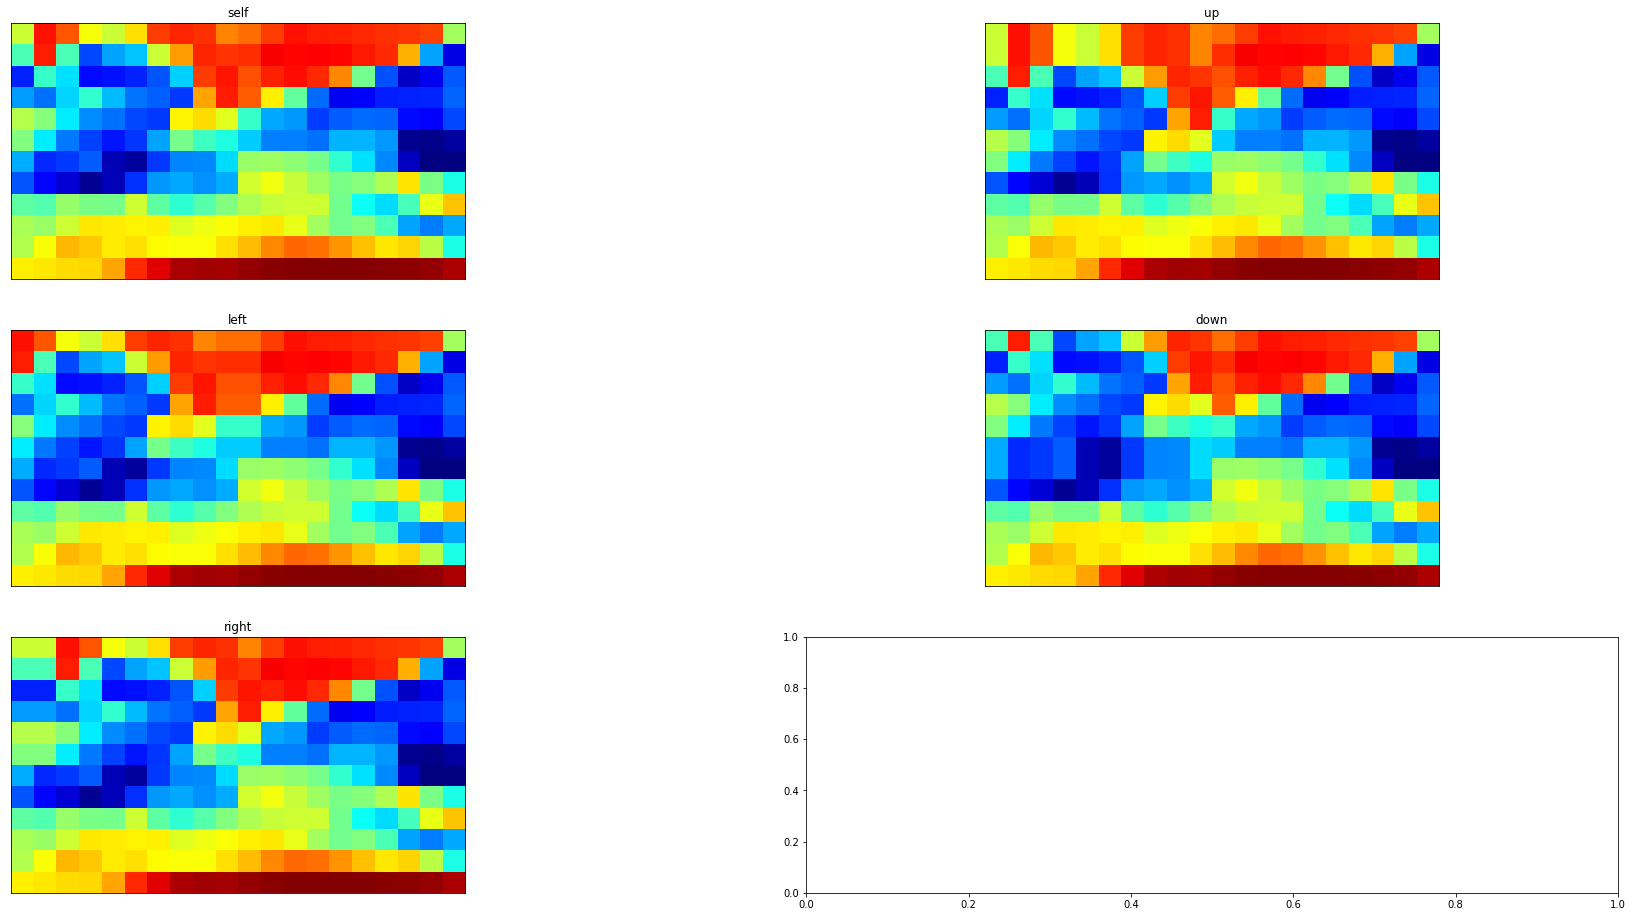

In [93]:
visual.process_image(scale=0)
visual.show_patches(heatmap=True, neighbours=[0,1,2,3,4], image_array_shape=(3,2), figsize=(16,32), 
                    titles=['self', 'up', 'left', 'down', 'right'])

## Column patching:

In [371]:
patches.process_columns(function=create_local_feature_vector, name='columns')

In [372]:
patches.columns.shape

(4, 160, 5, 34)

# Scaling

-  Scale 1x1 we have 9 feature vectors (local + 4 neighbours + 4 columns)
- At larger scales we have 5 (local + neighbours)

At larger scales 'neighbouring' subpatches are all contained within the same patch. As such there is no overlap of neighbours and they must be processed for each patch

In [47]:
show_function(scaled_patch)

def scaled_patch(patch, patchsize, scale, function, sub=False):
    subpatches = []
    centre = (int(scale[0]/2)*patchsize[0], int(scale[1]/2)*patchsize[1])
    order = [(-1,0),(0,1),(1,0),(0,-1)]
    centre_patch = function(patch[centre[0]:centre[0]+patchsize[0], centre[1]:centre[1]+patchsize[1]])
    
    if not sub:
        subpatches[0] = centre_patch

    for (y,x) in order:
        start = (centre[0]+(y*patchsize[0]), centre[1]+(x*patchsize[1]))
        end = (start[0]+patchsize[0], start[1]+patchsize[1])
        if sub:
            subpatches.append(centre_patch - function(patch[start[0]:end[0], start[1]:end[1]]))
        else :
            subpatches.append(function(patch[start[0]:end[0], start[1]:end[1]]))
    return subpatches

In [13]:
show_function(get_scaled_features)

def get_scaled_features(image, patchsize, scales, function=create_local_feature_vector, sub=False):
    scaled_features = []

    for (dy,dx) in tqdm(scales, total=len(scales), desc='Scales'):
        scaled_image = cv2.resize(image, (0,0), fx=dx, fy=dy)
        scaled_patchsize = (patchsize[0] * dy, patchsize[1] * dx)
        scaled_features.append(process_patches(scaled_image, patchsize=scaled_patchsize, 
                        function=lambda patch : scaled_patch(patch, patchsize, (dy,dx), function, sub), name=f'{dy}x{dx}'))
    
    return scaled_features

In [373]:
for i in range(2):
    patches.process_image(scale=i+1, function=create_local_feature_vector)

In [376]:
visual.patches.shape

(2, 30, 40, 5, 1)

In [384]:
visual.patches[1, :, :, 0].shape

(30, 40, 1)

In [277]:
patches.patchsize

[6, 8]

In [345]:
patches.patches[1,2,0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [283]:
np.all(patches.patches[1,0,0,0] != patches.patches[1,0,0,2])

True

In [182]:
scaled_features[0].shape

(30, 40, 5, 34)

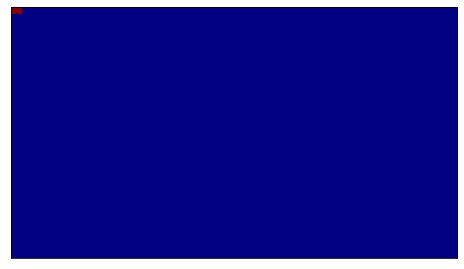

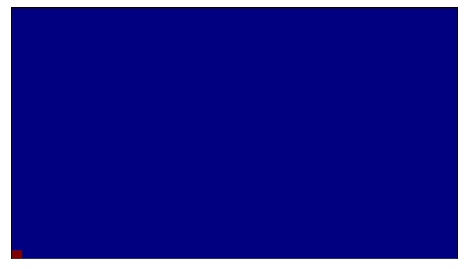

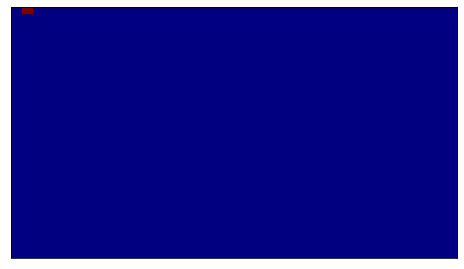

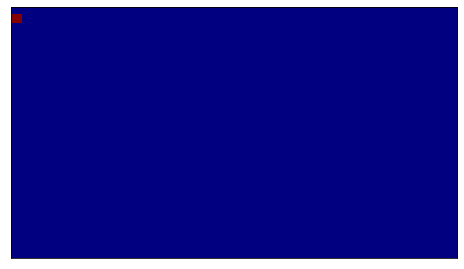

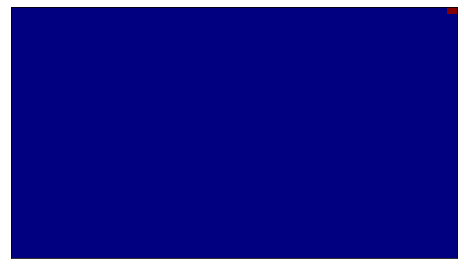

In [394]:
visual = Patches(bgr, 24, (1,), scales=[(1,1),(3,3), (9,9)], neighbour_order=[(0,0), (-1,0), (0,1), (1,0), (0,-1)], hide=True)
visual.process_image(scale=1)
for i in range(len(patches.neighbour_order)):
    visual.show_patches(scale=1, target=i, heatmap=True)

In [14]:
show_function(get_absolute_depth)

def get_absolute_depth(image, patchsize, scales):
    patchsize = get_patchsize(image.shape, patchsize)
    
    #Process local features at scale 1
    global_features = process_patches(image, patchsize, function=create_global_feature_vectors, name='local')

    # Process neighbouring features at scale 1
    set_adjacent(global_features)

    # Process columns at scale 1
    columnsize = (int(image.shape[0]/4),patchsize[1])
    column_features = process_patches(image, columnsize, function=create_local_feature_vector, name='columns')

    for x in range(column_features.shape[1]):
        global_features[:,x,-4:] = column_features[:, x]
    
    # calculate the subpatches at scales
    scaled_features = get_scaled_features(image, patchsize, scales)
    
    return global_features, scaled_features

In [122]:
global_features, scaled_features = get_absolute_depth(ycc, 60, [(3,3), (3,3)])

In [123]:
global_features.shape
scaled_features[0].shape
scaled_features[1].shape

(12, 20, 9, 34)

(12, 20, 5, 34)

(12, 20, 5, 34)

## Flatten

In preparation for calculating the weights we will need to produce a flattened vector of the features at each patch

In [150]:
np.concatenate((global_features, *scaled_features),2).reshape(*global_features.shape[:2], -1).shape

(12, 20, 646)

# Histogram of features - calculating relative depth

To calculate relative depth between patches we create a histogram of the 17 features

In [15]:
show_function(get_relative_histograms)

def get_relative_histograms(image, patchsize, scales):
    patchsize = get_patchsize(image.shape, patchsize)
    
    histogram_10 = lambda feature : np.histogram(feature, bins=10)[0]
    local_hist = lambda  patch : create_local_feature_vector(patch, squares=False, function=histogram_10)
    global_hist = lambda  patch : create_feature_vector_with_neighbours(patch, squares=False, function=histogram_10)    
    
    relative_depths = [process_patches(image, patchsize, function=global_hist)]
    relative_depths[0] = subtract_adjacent(relative_depths[0])
    
    relative_depths += get_scaled_features(image, patchsize, scales, local_hist, sub=True) 
    
    return relative_depths

In [138]:
relative_histograms = get_relative_histograms(ycc, get_patchsize(ycc.shape, 24), [(3,3), (9,9)])

In [139]:
relative_histograms[0].shape
relative_histograms[1].shape
relative_histograms[2].shape

(30, 40, 4, 17, 10)

(30, 40, 4, 17, 10)

(30, 40, 4, 17, 10)

# Combining the information

For the Markov Random Field equation we need 2 set of information:
1. The absolute depth at each patch, which we will flatten into a 1d array
1. The histogram of depth, for calculating the relative depth

In [16]:
show_function(get_absolute_and_relative_depth)

def get_absolute_and_relative_depth(image, patchsize, scales):
    patchsize = get_patchsize(image.shape, patchsize)
    scale_1, larger_scales = get_absolute_depth(image, patchsize, scales)
    absolute_depth = np.concatenate((scale_1, *larger_scales),2).reshape(*scale_1.shape[:2], -1)
    
    relative_histogram = get_relative_histograms(image, patchsize, scales)
    
    return absolute_depth, relative_histogram

In [195]:
absolute_depth, histogram_10 = get_absolute_and_relative_depth(ycc, 24, [(3,3),(9,9)])

In [197]:
absolute_depth.shape
histogram_10.shape

(30, 40, 646)

(30, 40, 17, 10)